In [1]:
from dataAnalysis import *
from myKriging import *
from draw import *
import time
import gc
import cupy as cp
np.set_printoptions(threshold=100)

In [2]:
data = get_data("basicflair_21.xlsx", sheet_name_template="idx=z", usecols=("B:CW"), z_size=100, y_size=100)

In [3]:
def create_coordinates_broadcast(step_size):
  """
  使用 NumPy 广播机制创建坐标数组。

  Args:
    step_size: 坐标步长。

  Returns:
    numpy 数组: 包含所有坐标的三维 numpy 数组。
  """
  x = np.arange(4, 99, 0.2 * step_size)[:, None, None]
  y = np.arange(4, 99, 0.2 * step_size)[None, :, None]
  z = np.arange(4, 99, 0.2 * step_size)[None, None, :]
  
  # 确保 x, y, z 形状一致
  x = np.broadcast_to(x, (x.shape[0], y.shape[1], z.shape[2]))
  y = np.broadcast_to(y, (x.shape[0], y.shape[1], z.shape[2]))
  z = np.broadcast_to(z, (x.shape[0], y.shape[1], z.shape[2]))
  return np.stack((x, y, z), axis=3).reshape(-1,3)

In [4]:
time_list_cpu = []
time_list_gpu = []
point_nums = []
df_testing = testing_sampling(data, 4, 4, 4, 95, step_sizes=[2], direction = "3vector", sample_like_training = True)

for step_size in [[16],[15],[13],[11],[10],[9],[8],[7],[6]]:
    df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=step_size, x_y_reverse = False, direction = "3vector")
    df_training.drop_duplicates(inplace=True)  # 删除重复行
    point_nums.append(df_training.shape[0])
    model = training(df_training, 
                 variogram_model="exponential", 
                 nlags = 20, 
                 enable_plotting=False, 
                 weight=True, 
                 uk=False)
    begin_gpu = time.time()
    # multi_process和torch_ac只用一个
    testing_value_gpu = testing(df_testing, 
                                model,
                                block_size = 50000, 
                                cpu_on = False,
                                compute_precision = False)
    end_gpu = time.time()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    gc.collect()
    time_list_gpu.append(end_gpu - begin_gpu)

for step_size in [[16],[15],[13],[11],[10],[9],[8],[7],[6]]:
    df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=step_size, x_y_reverse = False, direction = "3vector")
    df_training.drop_duplicates(inplace=True)  # 删除重复行
    model = training(df_training, 
                 variogram_model="exponential", 
                 nlags = 20, 
                 enable_plotting=False, 
                 weight=True, 
                 uk=False)
    begin_cpu = time.time()
    print("cpu blocksize is",512*884735 // ((95//step_size[0]+1)**3))
    testing_value = testing(df_testing, 
                            model, 
                            block_size = 512*884735 // ((95//step_size[0]+1)**3), 
                            cpu_on = True,
                            compute_precision = False)
    end_cpu = time.time()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    gc.collect()
    time_list_cpu.append(end_cpu - begin_cpu)

time_list_cpu = time_list_cpu[1:]
time_list_gpu = time_list_gpu[1:]
point_nums = point_nums[1:]

init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.34

init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.11

init消耗时间为0.02

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.01

execute消耗时间为0.13

init消耗时间为0.04

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.01

execute消耗时间为0.17

init消耗时间为0.06

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.02

execute消耗时间为0.21

init消耗时间为0.10

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.04

execute消耗时间为0.31

init消耗时间为0.31

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.11

execute消耗时间为0.58

init消耗时间为0.71

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.25

execute消耗时间为1.21

init消耗时间为0.01

cpu blocksize is 2097149
预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

_exec_vector_cpu消耗时间为0.86

execute消耗时间为0.94

init消耗时间为0.01

cpu blocksize is 1320653
预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

_exec_vector_cpu消耗时间为1.49

execute消耗时间为1.61

init消耗时间为0.02

cpu blocksize is 884735
预测矩阵中有 0 个0
_get_kriging_matrix消

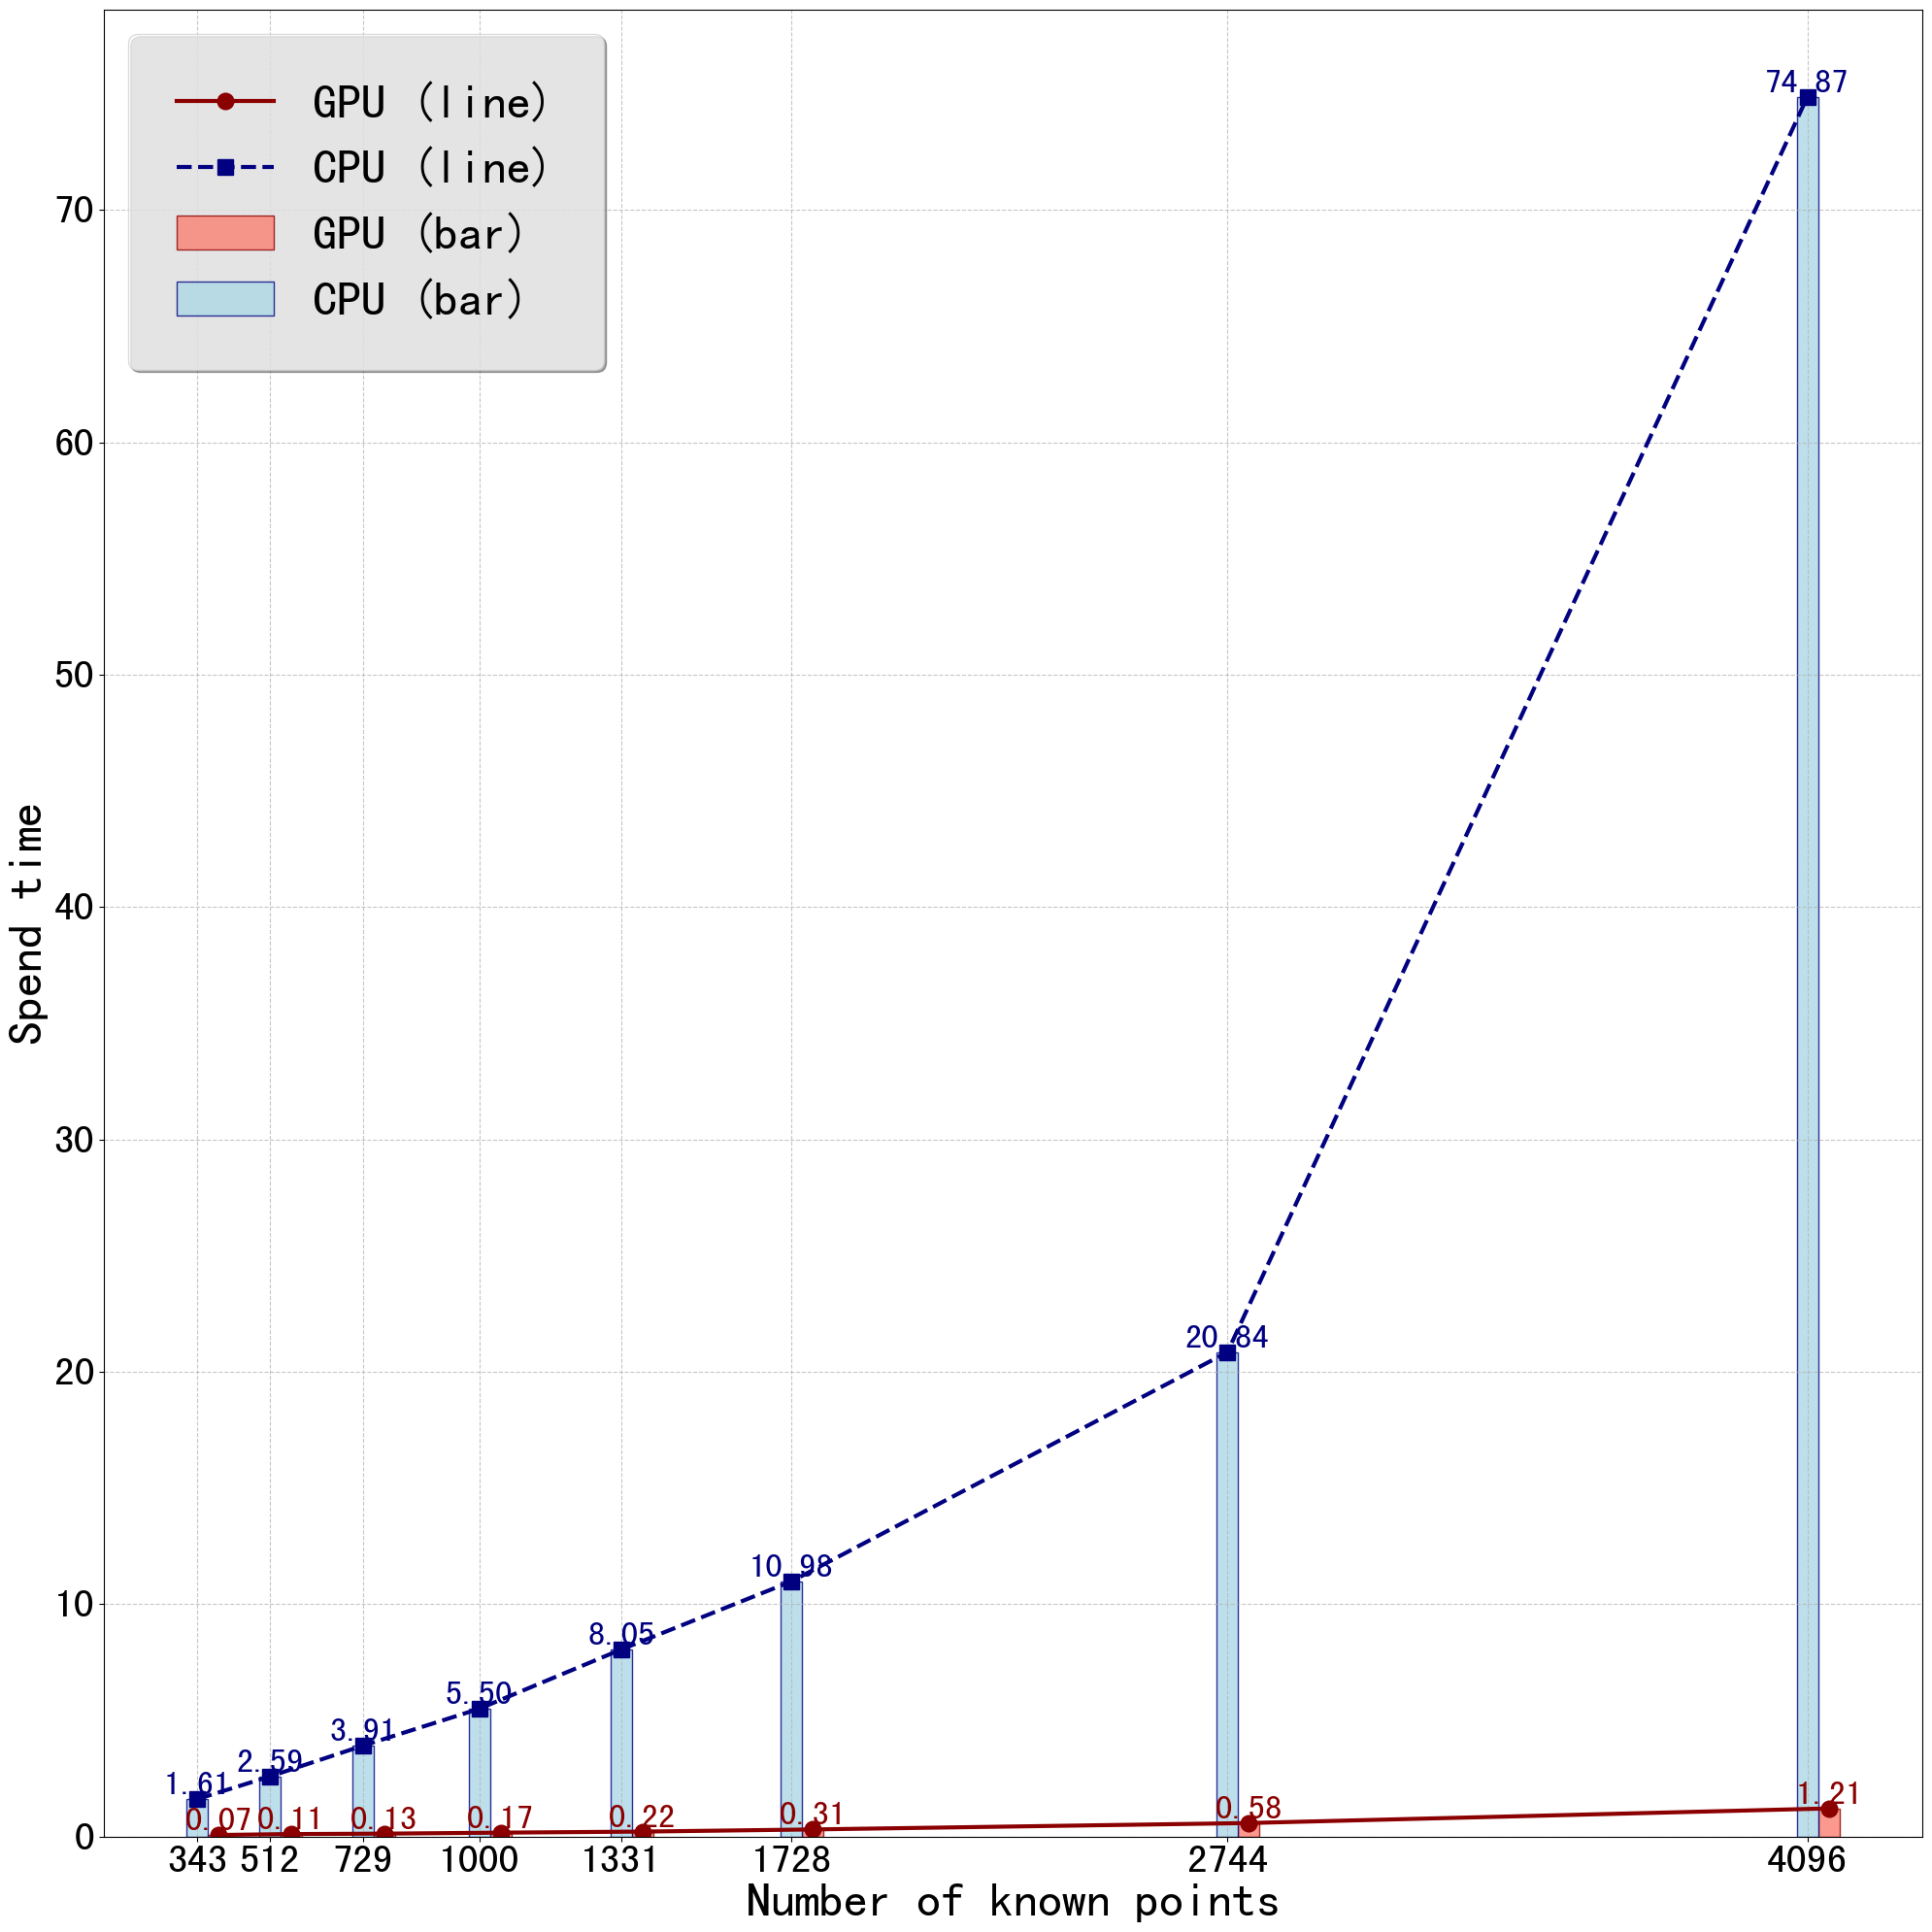

In [5]:

# 创建图形
plt.figure(figsize=(20, 20))  # 尺寸乘以2

# 定义颜色和样式
line_styles = {
    'GPU': {'color': 'darkred', 'linestyle': '-', 'marker': 'o'},
    'CPU': {'color': 'navy', 'linestyle': '--', 'marker': 's'}
}
bar_colors = {
    'GPU': {'color': 'salmon', 'edgecolor': 'darkred'},
    'CPU': {'color': 'lightblue', 'edgecolor': 'navy'}
}
# 绘制柱状图
bar_width = 50  # 调整柱状图宽度
index = np.arange(len(point_nums))
# 绘制折线图
plt.plot([i + bar_width for i in point_nums], time_list_gpu, label="GPU (line)", 
         marker=line_styles['GPU']['marker'], linestyle=line_styles['GPU']['linestyle'], 
         linewidth=3, color=line_styles['GPU']['color'], markersize=12)
plt.plot(point_nums, time_list_cpu, label="CPU (line)", 
         marker=line_styles['CPU']['marker'], linestyle=line_styles['CPU']['linestyle'], 
         linewidth=3, color=line_styles['CPU']['color'], markersize=12)

# 修正柱状图位置
bars1 = plt.bar([i + bar_width for i in point_nums], time_list_gpu, bar_width, label='GPU (bar)', 
                color=bar_colors['GPU']['color'], edgecolor=bar_colors['GPU']['edgecolor'], alpha=0.8)
bars2 = plt.bar(point_nums, time_list_cpu, bar_width, label='CPU (bar)', 
                color=bar_colors['CPU']['color'], edgecolor=bar_colors['CPU']['edgecolor'], alpha=0.8)

# 设置图表的标签和刻度
plt.xlabel("Number of known points", fontsize=36, fontweight='bold')  # 字体大小乘以2
plt.ylabel("Spend time", fontsize=36, fontweight='bold')  # 字体大小乘以2
plt.xticks(point_nums, fontsize=30)  # 字体大小乘以2
plt.yticks(fontsize=30)  # 字体大小乘以2
plt.grid(True, linestyle='--', alpha=0.7)

# 为每个柱添加数值标签
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=25, color='darkred', fontweight='bold')  # 字体大小乘以2

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=25, color='navy', fontweight='bold')  # 字体大小乘以2

# 设置图例
plt.legend(fontsize=36, loc='upper left', frameon=True, fancybox=True, framealpha=0.7, shadow=True, borderpad=1)  # 字体大小乘以2

# 调整图表的样式
plt.rcParams['axes.linewidth'] = 3  # 加粗坐标轴
plt.rcParams['xtick.major.size'] = 12  # 放大刻度标记
plt.rcParams['ytick.major.size'] = 12

# 调整布局
plt.tight_layout()

# 保存和显示图表
plt.savefig(r"TimeWithTraningPoints.pdf", format="pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [6]:
# 预测加速比(发现已知点512时加速很大，怀疑和1024这个大小有关)
[time_list_cpu[i]/time_list_gpu[i] for i in range(len(time_list_cpu))]

[23.04950953678474,
 23.7920499962709,
 30.852466290983415,
 32.50274361373526,
 37.42136038754853,
 35.70551633695137,
 35.718971706904924,
 61.75863552746523]

In [7]:
# 预测时间列表
list(zip(point_nums, time_list_gpu, time_list_cpu))

[(343, 0.06999969482421875, 1.6134586334228516),
 (512, 0.1086888313293457, 2.585930109024048),
 (729, 0.12679839134216309, 3.9120430946350098),
 (1000, 0.16919326782226562, 5.4992454051971436),
 (1331, 0.21512198448181152, 8.050157308578491),
 (1728, 0.30760860443115234, 10.98332405090332),
 (2744, 0.5835602283477783, 20.844171285629272),
 (4096, 1.2123265266418457, 74.87163209915161)]

In [32]:
time_list_cpu = []
time_list_gpu = []
point_nums = []
df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=[13], x_y_reverse = False, direction = "3vector")
model = training(df_training, 
                 variogram_model="exponential", 
                 nlags = 20, 
                 enable_plotting=False, 
                 weight=True, 
                 uk=False)

for step_size in list(range(10,1,-1)):
    coordinates_test = create_coordinates_broadcast(step_size)
    print("当前预测点数为：",(coordinates_test.shape[0]))
    point_nums.append(coordinates_test.shape[0])
    # block_size_gpu = 50000
    block_for10 = (475//step_size+475%step_size)**3//10
    block_size_gpu = min(250000, max(block_for10-block_for10%5000, 20000)) #单线程下120000*8
    print("block_size_gpu is ", block_size_gpu)
    gpu_time = testing_for_time(coordinates_test, 
                    model,
                    block_size = block_size_gpu,
                    cpu_on = False)

    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    del coordinates_test
    gc.collect()
    time_list_gpu.append(gpu_time)

for step_size in list(range(10,1,-1)):
    coordinates_test = create_coordinates_broadcast(step_size)
    print("当前预测点数为：",(coordinates_test.shape[0]))
    block_size_cpu = 884735
    print("block_size_cpu is ", block_size_cpu)
    cpu_time = testing_for_time(coordinates_test, 
                model,
                # 512*884735为cpu最高能承受的量 //后面接已知点数, 
                # 但是当step=1时, execute里会出现另一个很占内存的对象，导致分配不了这么高，所以改为400000
                block_size = block_size_cpu, 
                cpu_on = True,
                multi_process=False,
                torch_ac= False)
    del coordinates_test
    gc.collect()
    time_list_cpu.append(cpu_time)

init消耗时间为0.02

当前预测点数为： 110592
block_size_gpu is  20000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.47

当前预测点数为： 148877
block_size_gpu is  20000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.13

当前预测点数为： 216000
block_size_gpu is  20000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.20

当前预测点数为： 314432
block_size_gpu is  35000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.23

当前预测点数为： 512000
block_size_gpu is  50000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.32

当前预测点数为： 857375
block_size_gpu is  85000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.50

当前预测点数为： 1685159
block_size_gpu is  175000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.94

当前预测点数为： 4019679
block_size_gpu is  250000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为2.33

当前预测点数为： 13481272
block_size_gpu is  250000
_get_kriging_matrix消耗时间为0.00

execute消耗时间为7.77

当前预测点数为： 110592
block_size_cpu is  884735
_get_kriging_matrix消耗时间为0.00

_exec_vector_cpu消耗时间为2.33

execute消耗时间为2.52

当前预测点数为： 148877
block_size_cpu is  884735
_get_kriging_matri

KeyboardInterrupt: 

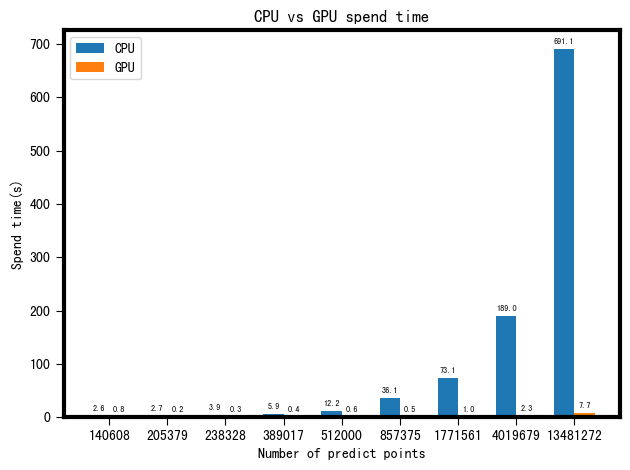

In [ ]:

# 创建柱状图
width = 0.35  # 柱状图宽度

# x 轴位置
x = np.arange(len(point_nums))

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, time_list_cpu, width, label='CPU')
rects2 = ax.bar(x + width/2, time_list_gpu, width, label='GPU')

# 添加标签，标题和图例
ax.set_ylabel('Spend time(s)')
ax.set_xlabel('Number of predict points')
ax.set_title('CPU vs GPU spend time')
ax.set_xticks(x)
ax.set_xticklabels(point_nums)
ax.legend()

# 添加每个柱状图的数值标签
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig(r"TimeWithPredictPoints.pdf", format="pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [22]:
# 预测加速比
[time_list_cpu[i]/time_list_gpu[i] for i in range(len(time_list_cpu))]

[3.13915943594318,
 12.959969115638177,
 14.058223002490223,
 14.83608807225831,
 18.795485874594824,
 70.01485572295847,
 76.6559926441193,
 81.08677903764395,
 90.15543469481082]

In [23]:
# 预测时间列表
list(zip(point_nums, time_list_gpu, time_list_cpu, [time_list_cpu[i]/time_list_gpu[i] for i in range(len(time_list_cpu))]))

[(140608, 0.8291058540344238, 2.6026954650878906, 3.13915943594318),
 (205379, 0.2087411880493164, 2.7052793502807617, 12.959969115638177),
 (238328, 0.27391743659973145, 3.850792407989502, 14.058223002490223),
 (389017, 0.40043115615844727, 5.940831899642944, 14.83608807225831),
 (512000, 0.649627685546875, 12.210067987442017, 18.795485874594824),
 (857375, 0.5152511596679688, 36.07523560523987, 70.01485572295847),
 (1771561, 0.9542083740234375, 73.14579010009766, 76.6559926441193),
 (4019679, 2.3303160667419434, 188.9578239917755, 81.08677903764395),
 (13481272, 7.6654956340789795, 691.0860910415649, 90.15543469481082)]

In [12]:
time_list_cpu_2 = []
time_list_gpu_2 = []

# 测试当已知点数为8的指数时是否有利于提高GPU加速比
df_testing = testing_sampling(data, 4, 4, 4, 95, step_sizes=[1], direction = "3vector", sample_like_training = True)

for step_size in [[14],[13],[13,16],[7],[6],[15,6]]:
    df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=step_size, x_y_reverse = False, direction = "3vector")
    df_training.drop_duplicates(inplace=True)  # 删除重复行
    df_training.reset_index(drop=True, inplace=True)  # 重新设置索引
    model = training(df_training, 
                 variogram_model="exponential", 
                 nlags = 20, 
                 enable_plotting=False, 
                 weight=True, 
                 uk=False)
    begin_gpu = time.time()
    # multi_process和torch_ac只用一个
    testing_value_gpu = testing(df_testing, 
                                model,
                                block_size = 51200, 
                                cpu_on = False,
                                compute_precision = False)
    end_gpu = time.time()
    
    time_list_gpu_2.append(end_gpu - begin_gpu)
    
    df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=step_size, x_y_reverse = False, direction = "3vector")
    
    model = training(df_training, 
                 variogram_model="exponential", 
                 nlags = 20, 
                 enable_plotting=False, 
                 weight=True, 
                 uk=False)
    begin_cpu = time.time()
    print("cpu blocksize is",512*884735 // df_training.shape[0])
    testing_value = testing(df_testing, 
                            model, 
                            block_size = 512*884735 // df_training.shape[0], 
                            cpu_on = True,
                            compute_precision = False)
    end_cpu = time.time()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    del df_training
    gc.collect()
    time_list_cpu_2.append(end_cpu - begin_cpu)

init消耗时间为0.02

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.79

init消耗时间为0.01

cpu blocksize is 1320653
预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

_exec_vector_cpu消耗时间为14.04

execute消耗时间为15.12

init消耗时间为0.02

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.01

execute消耗时间为0.90

init消耗时间为0.02

cpu blocksize is 884735
预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

_exec_vector_cpu消耗时间为49.76

_exec_vector_cpu消耗时间为0.22

execute消耗时间为51.97

init消耗时间为0.05

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.01

execute消耗时间为1.41

init消耗时间为0.03

cpu blocksize is 622231
预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.01

_exec_vector_cpu消耗时间为43.21

_exec_vector_cpu消耗时间为7.77

execute消耗时间为53.75

init消耗时间为0.68

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.11

execute消耗时间为4.35

init消耗时间为0.38

cpu blocksize is 165081
预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.11

_exec_vector_cpu消耗时间为53.01

_exec_vector_cpu消耗时间为52.07

_exec_vector_cpu消耗时间为52.69

_exec_vector_cpu消耗时间为58.61

_exec_vector_cpu消耗时间为53.96

_exec_vector_cpu消耗时间为12.58

execute消耗时间为

In [13]:
[time_list_cpu_2[i]/time_list_gpu_2[i] for i in range(len(time_list_cpu_2))]

[18.37474148194914,
 53.107292150035136,
 20.87227308197144,
 56.14868275101874,
 57.087212653895186,
 52.966201488924625]

In [15]:
point_nums_2 = []
for step_size in [[14],[13],[13,16],[7],[6],[15,6]]:
    df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=step_size, x_y_reverse = False, direction = "3vector")
    point_nums_2.append(df_training.shape[0])

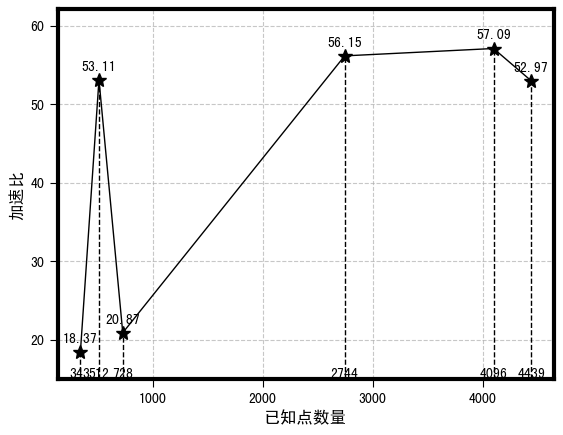

In [16]:
import matplotlib.pyplot as plt

# ... (Your existing code for plotting the data) ...

# Customize plot for a retro feel
plt.rcParams['axes.linewidth'] = 3  # Thicker axes
plt.rcParams['xtick.major.size'] = 6  # Larger tick marks
plt.rcParams['ytick.major.size'] = 6

# Add vertical lines and annotations only below data points
speedups = [time_list_cpu_2[i]/time_list_gpu_2[i] for i in range(len(time_list_cpu_2))]
for i, point_num in enumerate(point_nums_2):
    speedup = speedups[i]

    # Adjust ymin and ymax to limit the line's length
    ymax_value = max(speedups)
    ymax = (speedup - 15)/(ymax_value - 10)
    plt.axvline(x=point_num, color='black', linestyle='--', linewidth=1, ymin=0, ymax=ymax)  # Vertical line
    plt.text(point_num, 15+1.5, str(point_num), ha='center', va='top', fontsize=10)  # X-coordinate label
    plt.text(point_num, speedup + 1, f"{speedup:.2f}", ha='center', va='bottom', fontsize=10)  # Speedup label

# Change marker to star and line color to black
plt.plot(point_nums_2, speedups, 
         marker='*', linestyle='-', linewidth=1, color='black', markersize=10)

# 设置 y 轴范围从 15 开始
plt.ylim(15, max(speedups) + 5)  # 这里将最大值加 1 以确保所有数据点可见

# Set plot aesthetics
plt.xlabel("已知点数量", fontsize=12, fontweight='bold')
plt.ylabel("加速比", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig(r"TimeWithTrainingPoints2.pdf", format="pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [8]:
# 测试不同分块下不同预测点数所消耗的时间
import time
point_testing_list = list(range(7,3,-1))
block_sizes = [5000*i for i in range(1,100)]
times_testing = {}
df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=[13], x_y_reverse = False, direction = "3vector") #512个训练点
for point_testing in point_testing_list:
    time_p = []
    coordinates_test = create_coordinates_broadcast(point_testing)
    for block_size in block_sizes:

        model = training(df_training, 
                variogram_model="exponential", 
                nlags = 20, 
                enable_plotting=False, 
                weight=True, 
                uk=False)
        gpu_time = testing_for_time(coordinates_test, 
                model,
                block_size = block_size,
                cpu_on = False)
        time_p.append(gpu_time)
    times_testing[point_testing] = time_p

init消耗时间为0.03

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.58

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.12

init消耗时间为0.01

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.10

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.09

init消耗时间为0.01

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.09

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.08

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.08

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.01

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.08

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.01

_get_kriging_matrix消耗时间为0.00

execute消耗时

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.07

init消耗时间为0.02

_get_kriging_matrix消耗时

In [9]:
cp.get_default_memory_pool().free_all_blocks()
cp.get_default_pinned_memory_pool().free_all_blocks()

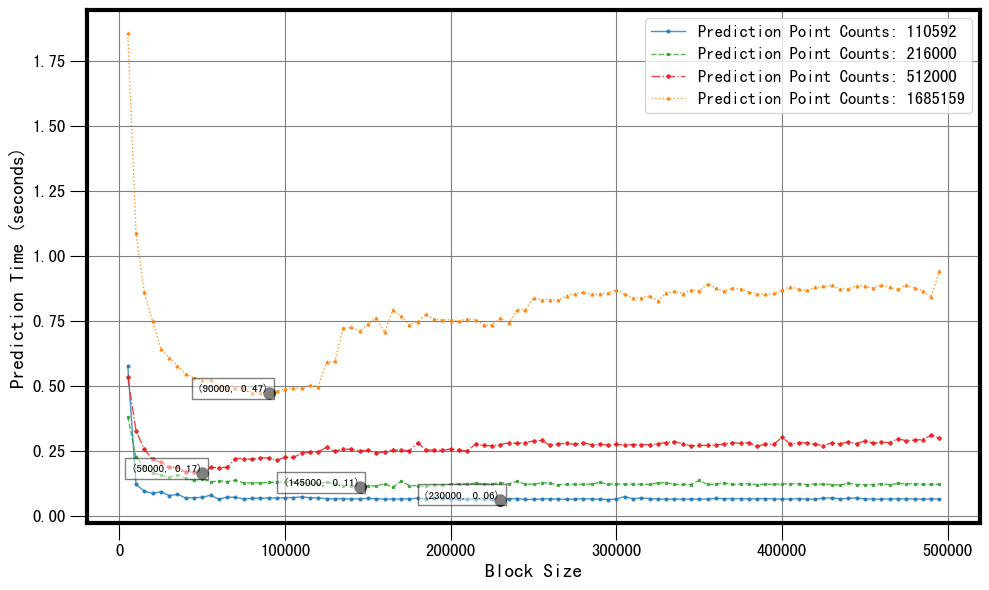

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the code and obtained times_testing, block_sizes, point_testing_list

# Create the figure
plt.figure(figsize=(10, 6))

# Define linestyles for different prediction point counts
linestyles = ['-', '--', '-.', ':', 
              (0, (3, 1, 1, 1, 1, 1)), (0, (5, 5)), 
              (0, (3, 5, 1, 5, 1, 5)), (0, (5, 1, 1, 1, 1, 1)), 
              (0, (3, 1, 1, 1, 1, 1, 1, 1)), (0, (5, 1, 5, 1, 5, 1)), 
              (0, (3, 1, 1, 1, 1, 1, 1, 1, 1, 1))]  # Add more linestyles

# Define color list for different prediction point counts
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', 
          '#2878b5', '#b2df8a', '#fb9a99', '#FFC300', '#cab2d6', '#ffff99',
          '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3', '#b2df8a', '#fb9a99']  # Add more colors

# Define marker styles for different prediction point counts
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '*', 'x', 'd', '+', '|', '_', 'P', 'X', '8']

# Plot the time curves for different prediction point counts
for i, point_testing in enumerate(point_testing_list):

    
    # Shorten the lines by cutting off some data points
    shortened_block_sizes = block_sizes[:len(block_sizes)]
    shortened_times = times_testing[point_testing][:len(block_sizes)]

    plt.plot(shortened_block_sizes, shortened_times,  # Plot shortened data
             label=f"Prediction Point Counts: {(475//point_testing+1)**3}",  # Changed label
             color=colors[i], 
             linestyle=linestyles[i],
             marker=markers[i],  # Set marker style
             markersize=2,  # Set marker size
             alpha=0.8,  # Set color opacity
             linewidth=1)  # Set line width

    # Find the minimum value and its index
    min_index = np.argmin(shortened_times)
    min_value = shortened_times[min_index]

    # Mark the minimum point with a circle
    plt.plot(shortened_block_sizes[min_index], min_value, 'o', color='black', markersize=8)
    
    # Add a text annotation at the minimum point
    plt.text(shortened_block_sizes[min_index], min_value, 
             f"({shortened_block_sizes[min_index]}, {min_value:.2f})", 
             fontsize=8, 
             ha='right', 
             va='bottom',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
# Set chart title and axis labels
plt.xlabel("Block Size", fontsize=14)
plt.ylabel("Prediction Time (seconds)", fontsize=14)  # Changed label

# Set tick font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Set chart background to white, grid lines to gray, and adjust grid line transparency
plt.grid(True, color='gray')
plt.gca().set_facecolor('white')

# Adjust spacing for better aesthetics
plt.tight_layout()

plt.savefig(r"TimeWithTestingAndBlocks.pdf", format="pdf", bbox_inches='tight', dpi=300, transparent=True)
# Display the chart
plt.show()



In [20]:
# 测试不同分块下不同训练点数所消耗的时间
import time
point_training_list = [15,13,11,10]
block_sizes = [5000*i for i in range(1,100)]
times_training = {}
df_testing = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=[1], x_y_reverse = False, direction = "3vector") #80万个预测点
for point_training in point_training_list:
    time_p = []
    df_training = training_sampling(data, 4, 4, 4 ,95 ,step_sizes=[point_training], x_y_reverse = False, direction = "3vector")
    for block_size in block_sizes:
        model = training(df_training, 
                variogram_model="exponential", 
                nlags = 20, 
                enable_plotting=False, 
                weight=True, 
                uk=False)
        begin = time.time()
        testing(df_testing, model, block_size=block_size, multi_process = False)
        end = time.time()
        time_p.append(end - begin)
    times_training[point_training] = time_p

init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为1.14

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.61

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.45

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.40

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.39

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.36

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.35

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.36

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix消耗时间为0.00

execute消耗时间为0.35

模型的平均相对误差2为 0.1626127970391828
init消耗时间为0.01

预测矩阵中有 0 个0
_get_kriging_matrix

In [18]:
import matplotlib.pyplot as plt

# Assuming you have already run the code and obtained times_training, block_sizes, point_training_list

# Create the figure
plt.figure(figsize=(10, 6))

# Define linestyles for different training point counts
linestyles = ['-', '--', '-.', ':', 
              (0, (3, 1, 1, 1, 1, 1)), (0, (5, 5)), 
              (0, (3, 5, 1, 5, 1, 5)), (0, (5, 1, 1, 1, 1, 1)), 
              (0, (3, 1, 1, 1, 1, 1, 1, 1)), (0, (5, 1, 5, 1, 5, 1)), 
              (0, (3, 1, 1, 1, 1, 1, 1, 1, 1, 1))]  # Add more linestyles

# Define color list for different training point counts
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', 
          '#2878b5', '#b2df8a', '#fb9a99', '#FFC300', '#cab2d6', '#ffff99',
          '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3', '#b2df8a', '#fb9a99']  # Add more colors

# Define marker styles for different training point counts
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', '*', 'x', 'd', '+', '|', '_', 'P', 'X', '8']

# Plot the time curves for different training point counts
for i, point_training in enumerate(point_training_list):
    # Shorten the lines by cutting off some data points
    shortened_block_sizes = block_sizes[:len(block_sizes)]
    shortened_times = times_training[point_training][:len(block_sizes)]
    
    plt.plot(block_sizes, times_training[point_training], 
             label=f"Training Point Counts: {(95//point_training)**3}",  # Changed label
             color=colors[i % len(colors)], 
             linestyle=linestyles[i % len(linestyles)],
             marker=markers[i % len(markers)],  # Set marker style
             markersize=2,  # Set marker size
             alpha=0.8,  # Set color opacity
             linewidth=1)  # Set line width

    # Find the minimum value and its index
    min_index = np.argmin(shortened_times)
    min_value = shortened_times[min_index]

    # Mark the minimum point with a circle
    plt.plot(shortened_block_sizes[min_index], min_value, 'o', color='black', markersize=8)

    # Add a text annotation at the minimum point
    plt.text(shortened_block_sizes[min_index], min_value, 
             f"({shortened_block_sizes[min_index]}, {min_value:.2f})", 
             fontsize=8, 
             ha='right', 
             va='bottom',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
# Set chart title and axis labels
plt.xlabel("Block Size", fontsize=14)
plt.ylabel("Prediction Time (seconds)", fontsize=14)  # Changed label

# Set tick font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Set chart background to white, grid lines to gray, and adjust grid line transparency
plt.grid(True, color='gray')
plt.gca().set_facecolor('white')

# Adjust spacing for better aesthetics
plt.tight_layout()

plt.savefig(r"TimeWithTrainingAndBlocks.pdf", format="pdf", bbox_inches='tight', dpi=300, transparent=True)
# Display the chart
plt.show()




NameError: name 'point_training_list' is not defined

<Figure size 1000x600 with 0 Axes>